In [1]:
import pandas as pd
import numpy as np
import sklearn
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq

In [2]:
train_group = pd.read_pickle('train_group_add_cookie.pickle')

train_group

user_id=train_group.index.get_level_values(0)

vacancy_id_=train_group.index.get_level_values(1)

df = pd.DataFrame(list(zip( user_id, vacancy_id_, train_group['event_type'].to_list())), columns = ['user_id', 'vacancy_id_', 'rating'])

data=df.groupby('user_id')['vacancy_id_']. nunique ()

df=df.loc[df['user_id'].isin(list(data[(data>=5) & (data<5000)].index))]

df


,user_id,vacancy_id_,rating
0,000089d26cdd49d68839c68bc10f2cf2,177380,1
1,000089d26cdd49d68839c68bc10f2cf2,181353,1
2,000089d26cdd49d68839c68bc10f2cf2,195890,1
3,000089d26cdd49d68839c68bc10f2cf2,205562,1
4,000089d26cdd49d68839c68bc10f2cf2,211064,1
...,...,...,...
4662685,ffffdb17f45b4032b386d691d52e6c00,107125,10
4662686,ffffdb17f45b4032b386d691d52e6c00,107893,10
4662687,ffffdb17f45b4032b386d691d52e6c00,150843,10
4662688,ffffdb17f45b4032b386d691d52e6c00,160164,10


In [9]:
train_group = pd.read_pickle('train_group_add_cookie.pickle')

train_group

user_id=train_group.index.get_level_values(0)

vacancy_id_=train_group.index.get_level_values(1)

df = pd.DataFrame(list(zip( user_id, vacancy_id_, train_group['event_type'].to_list())), columns = ['user_id', 'vacancy_id_', 'rating'])

data=df.groupby('user_id')['vacancy_id_']. nunique ()

df=df.loc[df['user_id'].isin(list(data[(data>=5) & (data<5000)].index))]

df

,user_id,vacancy_id_,rating
0,000089d26cdd49d68839c68bc10f2cf2,177380,1
1,000089d26cdd49d68839c68bc10f2cf2,181353,1
2,000089d26cdd49d68839c68bc10f2cf2,195890,1
3,000089d26cdd49d68839c68bc10f2cf2,205562,1
4,000089d26cdd49d68839c68bc10f2cf2,211064,1
...,...,...,...
4662685,ffffdb17f45b4032b386d691d52e6c00,107125,10
4662686,ffffdb17f45b4032b386d691d52e6c00,107893,10
4662687,ffffdb17f45b4032b386d691d52e6c00,150843,10
4662688,ffffdb17f45b4032b386d691d52e6c00,160164,10


**Prepare Data**

In [3]:
import tensorflow as tf
from tensorflow.python.keras.layers import  Input, Embedding, Dot, Reshape, Dense
from tensorflow.python.keras.models import Model


In [4]:
# all unique user_id
user_ids = df["user_id"].unique().tolist() 
num_all_user = len(user_ids)
print(num_all_user)

322214


In [5]:
# randomly select 90% users from dataset 
np.random.seed(123)
rand_userid = np.random.choice(user_ids, size = int(num_all_user * 0.9), replace=False)
sample_df = df.loc[df['user_id'].isin(rand_userid)]

In [6]:
sample_df = df

In [7]:
# userid, movieid encoding by indices
user_ids = sample_df['user_id'].unique()
num_users = len(user_ids)
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
sample_df['user_encoded'] = sample_df['user_id'].map(user2user_encoded)

In [8]:
vacancy_ids = sample_df['vacancy_id_'].unique()
num_vacancy = len(vacancy_ids)
vacancy2vacancy_encoded = {x: i for i, x in enumerate(vacancy_ids)}
vacancy_encoded2vacancy = {i: x for i, x in enumerate(vacancy_ids)}
sample_df['vacancy_encoded'] = sample_df['vacancy_id_'].map(vacancy2vacancy_encoded)

In [9]:
# train-test split
# train, test = train_test_split(sample_df, test_size = 0.2, random_state=123)
train = sample_df

In [10]:
num_train_user = len(np.unique(train['user_encoded']))
num_train_vacancy = len(np.unique(train['vacancy_encoded']))

In [11]:
print(f'total vacancy: {num_vacancy}', 
      f'\nvacancy in train: {num_train_vacancy}', 
      f'\nvacancy not in train: {num_vacancy - num_train_vacancy} ({1 - num_train_vacancy / num_vacancy :.2f})', 
      f'\n\ntotal user: {num_users}', 
      f'\nuser in train: {num_train_user}', 
      f'\nuser not in train: {num_users - num_train_user} ({1 - num_train_user / num_users :.2f})'
     )

total vacancy: 160162 
vacancy in train: 160162 
vacancy not in train: 0 (0.00) 

total user: 322214 
user in train: 322214 
user not in train: 0 (0.00)


**Embedding and Model**

In [12]:
# from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Concatenate, Dropout, Dense, BatchNormalization, concatenate, dot
from tensorflow.python.keras import optimizers
from keras.utils import plot_model, model_to_dot
from keras.constraints import non_neg
from IPython.display import SVG
from sklearn.metrics import mean_squared_error
import os

In [13]:
# input: an integer as embedding layer size, a float as drop out probability
# output: a keras NCF model with pre-constructed layers
def NCF_model(embed_size = 10, drop_out_prob = 0.2): 
    # define spaceholder of embedding inputs
    vacancy_input = tf.keras.layers.Input(shape=[1],name='vacancy-input')
    user_input = tf.keras.layers.Input(shape=[1], name='user-input')

    # MLP embeddings for both user and movie
    vacancy_embedding_mlp = Embedding(num_vacancy, embed_size, 
                                    name='vacancy-embedding-mlp')(vacancy_input)
    vacancy_vec_mlp = Flatten(name='flatten-vacancy-mlp')(vacancy_embedding_mlp)
    vacancy_vec_mlp = Flatten(name='flatten-vacancy-mlp')(vacancy_embedding_mlp)

    user_embedding_mlp = Embedding(num_users, embed_size, 
                                   name='user-embedding-mlp')(user_input)
    user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

    # MF embeddings for both user and movie
    vacancy_embedding_mf = Embedding(num_vacancy, embed_size, 
                                   name='vacancy-embedding-mf')(vacancy_input)
    vacancy_vec_mf = Flatten(name='flatten-vacancy-mf')(vacancy_embedding_mf)

    user_embedding_mf = Embedding(num_users, embed_size, 
                                  name='user-embedding-mf')(user_input)
    user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

    # MLP layers
    concat = concatenate([vacancy_vec_mlp, user_vec_mlp], axis=-1, name='concat')
    concat_dropout = Dropout(drop_out_prob)(concat)

    fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
    fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
    fc_1_dropout = Dropout(drop_out_prob)(fc_1_bn)

    fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
    fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
    fc_2_dropout = Dropout(drop_out_prob)(fc_2_bn)

    # Prediction from both layers
    pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
    pred_mf = dot([vacancy_vec_mf, user_vec_mf], axes=1, normalize=False)

    combine_mlp_mf = concatenate([pred_mf, pred_mlp], axis=-1, name='pred_mf')
    # Final prediction
    result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

    model = Model([user_input, vacancy_input], result)
    model.compile(optimizer=optimizers.adam_v2.Adam(learning_rate=0.01), loss='mean_squared_error')

    return model

In [14]:
model = NCF_model()


Metal device set to: Apple M1 Max


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 9,655,792
Trainable params: 9,655,492
Non-trainable params: 300
__________________________________________________________________________________________________


In [16]:
train

,user_id,vacancy_id_,rating,user_encoded,vacancy_encoded
0,000089d26cdd49d68839c68bc10f2cf2,177380,1,0,0
1,000089d26cdd49d68839c68bc10f2cf2,181353,1,0,1
2,000089d26cdd49d68839c68bc10f2cf2,195890,1,0,2
3,000089d26cdd49d68839c68bc10f2cf2,205562,1,0,3
4,000089d26cdd49d68839c68bc10f2cf2,211064,1,0,4
...,...,...,...,...,...
4662685,ffffdb17f45b4032b386d691d52e6c00,107125,10,322213,111124
4662686,ffffdb17f45b4032b386d691d52e6c00,107893,10,322213,136042
4662687,ffffdb17f45b4032b386d691d52e6c00,150843,10,322213,42958
4662688,ffffdb17f45b4032b386d691d52e6c00,160164,10,322213,59925


In [ ]:
# train NCF model on training data, embedding size 20, dropout rate as default
model = NCF_model(embed_size=20)
history = model.fit([train['user_encoded'], train['vacancy_encoded']], train['rating'], epochs=5)

pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

2023-04-30 18:39:17.615619: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5
 27288/145639 [====>.........................] - ETA: 35:33 - loss: 9.7344

In [78]:
# uncomment to save model as 'dl_model.h5'
model.save('dl_model_version_2.h5')

In [38]:
# uncomment to load model
from keras.models import load_model
model = load_model('dl_model_version_2.h5')

In [40]:
# rmse on testing set 
y_hat = np.round(model.predict([test['user_encoded'], test['vacancy_encoded']]), decimals=2)
y_true = test['rating']
print(f'testing rms: {mean_squared_error(y_true, y_hat)}')

18492/18492 [==============================] - 22s 1ms/step
testing rms: 9.471599612450891


In [41]:
# prediction sample
d = {'prediction': y_hat.tolist(), 'true_value': y_true.values.tolist()}
test_pred = pd.DataFrame(d)
test_pred.head(5)

,prediction,true_value
0,[7.099999904632568],10
1,[1.2699999809265137],1
2,[1.5800000429153442],1
3,[1.3600000143051147],1
4,[8.140000343322754],1


In [81]:
from sklearn.model_selection import KFold

# sample 100k from training set as validation set 
valid_df_size = 100000
valid_df = train
#.sample(n = int(valid_df_size), replace=False, random_state=123)
embedding_layers = [5, 10, 15, 20, 25, 30]

In [82]:
# input: validation data set, list of embedding layer size, drop-out probability, number of epochs, number of fold
# output: list of cv-rmse for each hyperparameter value
def NCF_cross_validation(cv_df, eb_layers, drop_prob = 0.2, epoch=10, n_split=4):
    cv_result = []

    for el in eb_layers:      
        temp_loss = []
        itr_idx = 0
        
        for train_idx, test_idx in KFold(n_split).split(cv_df):          
            cv_train_x = cv_df.iloc[train_idx][['user_encoded', 'vacancy_encoded']]
            cv_test_x = cv_df.iloc[test_idx][['user_encoded', 'vacancy_encoded']]
            cv_train_y = cv_df.iloc[train_idx]['rating']
            cv_test_y = cv_df.iloc[test_idx]['rating']

            model_cv = NCF_model()
            model_cv.fit([cv_train_x['user_encoded'], cv_train_x['vacancy_encoded']], cv_train_y, epochs=epoch)

            curr_loss = model_cv.evaluate([cv_df['vacancy_encoded'], cv_df['vacancy_encoded']], cv_df['rating'])
            temp_loss.append(curr_loss)         
            itr_idx += 1
            
        cv_result.append(sum(temp_loss) / n_split)
            
    return cv_result

In [83]:
cv_result = NCF_cross_validation(valid_df, embedding_layers)

Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 102s 48ms/step - loss: 11.9247
Epoch 2/3
2084/2084 [==============================] - 104s 50ms/step - loss: 8.2317
Epoch 3/3
3125/3125 [==============================] - 5s 1ms/step - loss: 10.8280
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 112s 53ms/step - loss: 11.9268
Epoch 2/3
2084/2084 [==============================] - 108s 52ms/step - loss: 7.9735
Epoch 3/3
3125/3125 [==============================] - 5s 2ms/step - loss: 11.1712
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 103s 49ms/step - loss: 11.8507
Epoch 2/3
2084/2084 [==============================] - 100s 48ms/step - loss: 8.1718
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.3619
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 102s 48ms/step - loss: 11.8652
Epoch 2/3
2084/2084 [==============================] - 108s 52ms/step - loss: 7.9178
Epoch 3/3
3125/3125 [==============================] - 5s 1ms/step - loss: 11.6567
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 98s 46ms/step - loss: 11.9174
Epoch 2/3
2084/2084 [==============================] - 99s 47ms/step - loss: 5.8551
Epoch 3/3
3125/3125 [==============================] - 5s 1ms/step - loss: 11.3562
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 103s 49ms/step - loss: 11.8774
Epoch 2/3
2084/2084 [==============================] - 103s 49ms/step - loss: 6.5940
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.0519
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 100s 47ms/step - loss: 11.9183
Epoch 2/3
2084/2084 [==============================] - 100s 48ms/step - loss: 5.9535
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.0329
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 100s 47ms/step - loss: 12.0147
Epoch 2/3
2084/2084 [==============================] - 100s 48ms/step - loss: 7.1017
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 10.9426
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 99s 47ms/step - loss: 11.9125
Epoch 2/3
2084/2084 [==============================] - 99s 47ms/step - loss: 9.3481
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.2451
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 100s 47ms/step - loss: 11.9213
Epoch 2/3
2084/2084 [==============================] - 99s 47ms/step - loss: 9.3508
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.4749
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 99s 47ms/step - loss: 11.9398
Epoch 2/3
2084/2084 [==============================] - 98s 47ms/step - loss: 9.1733
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.3365
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 100s 47ms/step - loss: 11.8711
Epoch 2/3
2084/2084 [==============================] - 100s 48ms/step - loss: 7.5818
Epoch 3/3
3125/3125 [==============================] - 5s 1ms/step - loss: 11.4048
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 99s 47ms/step - loss: 11.8942
Epoch 2/3
2084/2084 [==============================] - 99s 47ms/step - loss: 6.5410
Epoch 3/3
3125/3125 [==============================] - 5s 1ms/step - loss: 11.1455
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 99s 47ms/step - loss: 11.9170
Epoch 2/3
2084/2084 [==============================] - 109s 52ms/step - loss: 5.5110
Epoch 3/3
3125/3125 [==============================] - 5s 2ms/step - loss: 11.1060
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 103s 49ms/step - loss: 11.8463
Epoch 2/3
2084/2084 [==============================] - 123s 59ms/step - loss: 8.1939
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 11.2322
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 120s 57ms/step - loss: 11.9070
Epoch 2/3
2084/2084 [==============================] - 119s 57ms/step - loss: 8.8396
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.3026
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 104s 49ms/step - loss: 11.8764
Epoch 2/3
2084/2084 [==============================] - 106s 51ms/step - loss: 7.4445
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 10.9535
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 131s 62ms/step - loss: 11.8939
Epoch 2/3
2084/2084 [==============================] - 124s 60ms/step - loss: 8.3241
Epoch 3/3
3125/3125 [==============================] - 5s 2ms/step - loss: 11.6432


[Text(0.5, 0, 'Embedding Dim'),
 Text(0, 0.5, 'CV rmse'),
 Text(0.5, 1.0, '3-Fold CV')]

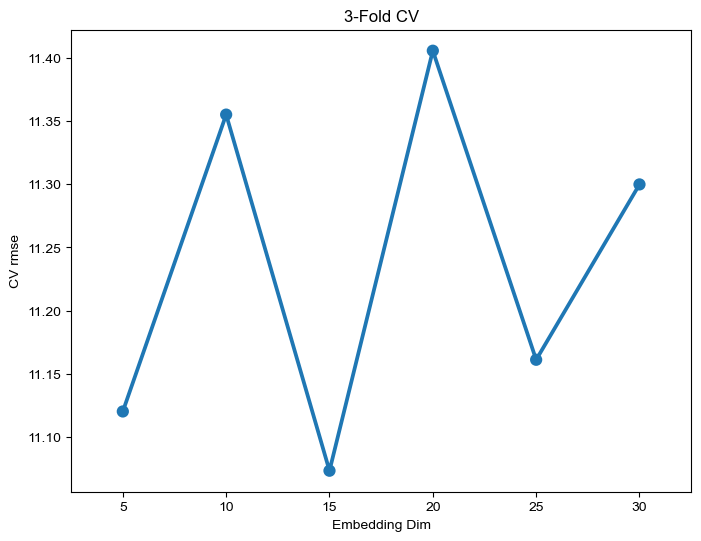

In [84]:
cv_result_df = pd.DataFrame({'cv_rmse': cv_result}, index = embedding_layers)

fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')
sns.pointplot(x=cv_result_df.index, y=cv_result_df.cv_rmse, ax=ax)
ax.set(xlabel='Embedding Dim', ylabel='CV rmse', title='3-Fold CV')

**Top 20 recommendations**

In [23]:
# input: a recommendation model (keras model), user id, number of recommendation
# output: a dataframe of top-k recommendations along with movie information
def NCF_recommendation(rec_model, client_id, top_k = 20):
    client_encoded = user2user_encoded[client_id]
    vacancy_watched = sample_df[sample_df['user_id'] == client_id]['vacancy_id_'].values
    
    vacancy_poll_encoded = []
    for item in vacancy_ids:
        if not np.isin(item, vacancy_watched):
            vacancy_poll_encoded.append(vacancy2vacancy_encoded[item])
            
    d = {'user_encoded': [client_encoded] * len(vacancy_poll_encoded), 'vacancy_encoded' : vacancy_poll_encoded}
    client_df = pd.DataFrame(d)
    
    ratings = rec_model.predict([client_df['user_encoded'], client_df['vacancy_encoded']])
    
    top_ratings_idx = ratings.flatten().argsort()[-top_k:][::-1]
    top_ratings = ratings[top_ratings_idx].flatten()
    recommend_vacancy = [vacancy_encoded2vacancy.get(vacancy_poll_encoded[x]) for x in top_ratings_idx]
    
    top_vacancy_rec = pd.DataFrame({'vacancy_id_': recommend_vacancy, 'prediction': top_ratings}).set_index('vacancy_id_')
    

    return top_vacancy_rec 

In [61]:
#client_id = int(np.random.choice(user_ids, 1))
print(f'recommendation for client: {client_id}')
NCF_recommendation(model, client_id, top_k=5)

recommendation for client: 84c24e67736849a6b9b99a81fbd179ca
4795/4795 [==============================] - 6s 1ms/step


,prediction
vacancy_id_,
207098,13.083969
122785,13.020906
244550,12.872283
180640,12.821929
217648,12.638739
